# Regresión logística y evaluación de clasificadores

El regresor logístico es un modelo que mapea una o más variables continuas a una variable objetivo binaria

Matemáticamente el modelo se define como

$$
f_\theta(\vec x_i) = \mathcal{S} \left(\theta_0 + \sum_{j=1}^M \theta_j x_{ij}\right) 
$$

donde $\theta_0, \theta_1, \ldots, \theta_M$ son los parámetros del modelo y $\mathcal{S}(z) = \frac{1}{1+\exp(-z)}$ se conoce como función logística o sigmoide

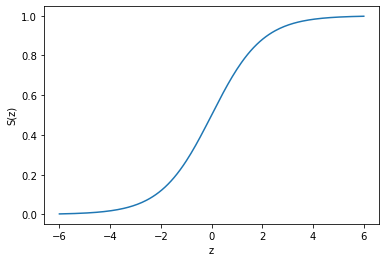

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

z = np.linspace(-6, 6, num=200)
sigmoid = lambda z: 1./(1+np.exp(-z))

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(z, sigmoid(z))
ax.set_xlabel('z')
ax.set_ylabel('S(z)');

Luego

- $f_\theta(\vec x_i)$ puede interpretarse como la probabilidad de que $x_i$ pertenezca  a la clase "1"
- $1-f_\theta(\vec x_i)$ puede interpretarse como la probabilidad de que $x_i$ pertenezca a la clase "0"

El modelo implementado en NumPy:

In [2]:
def logistic_regressor(theta, x):
    z = theta[0] + np.dot(x, theta[1:])
    return sigmoid(z)

Consideremos el siguiente conjunto de datos sintético de dos dimensiones:

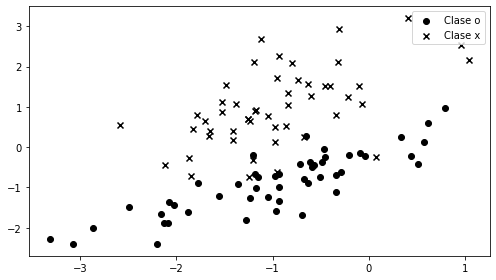

In [3]:
import sklearn.datasets
np.random.seed(20)
X, y = sklearn.datasets.make_classification(n_features=2, n_classes=2, n_informative=2, 
                                            n_redundant=0, n_clusters_per_class=1)

fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
for y_, marker in zip(np.unique(y), ['o', 'x']):
    mask = y == y_
    ax.scatter(X[mask, 0], X[mask, 1], c='k', marker=marker, label=f'Clase {marker}')
ax.legend();

Consideremos un modelo con los siguientes parámetros

In [4]:
theta = np.array([-2.5, -3.3, 5.])

La predicción del modelo en este espacio sería: 

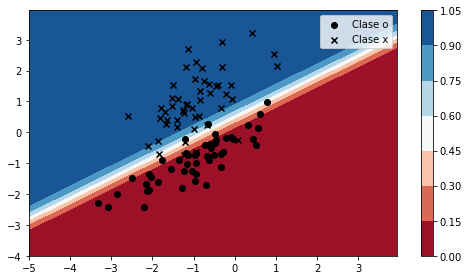

In [5]:
def plot_prediction(ax, theta, plot_data=True, colorbar=False):
    xx1, xx2 = np.meshgrid(np.arange(-5, 4, 0.05), np.arange(-4, 4, 0.05))
    preds = logistic_regressor(theta, np.stack((xx1.ravel(),xx2.ravel())).T)
    artist = ax.contourf(xx1, xx2, preds.reshape(xx1.shape), cmap=plt.cm.RdBu)
    if colorbar:
        fig.colorbar(artist, ax=ax)
    if plot_data:
        for y_, marker in zip(np.unique(y), ['o', 'x']):
            mask = y == y_
            ax.scatter(X[mask, 0], X[mask, 1], c='k', marker=marker, label=f'Clase {marker}')
        ax.legend();

fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
plot_prediction(ax, theta, colorbar=True)

> ¿Cómo se llega a estos valores para $\theta$?

Para entrenar este modelo se utiliza la siguiente función de costo 

$$
L(\theta) = \sum_{i=1}^N  -y_i \log( f_\theta(\vec x_i) ) - (1-y_i) \log(1 - f_\theta(\vec x_i))
$$

conocida como la **Entropía Cruzada Binaria** (*binary cross entropy*). En NumPy esto sería:



In [6]:
def bce_loss(theta, x, y, eps=1e-10):
    ypred = logistic_regressor(theta, x)
    return -np.sum(y*np.log(ypred+eps) + (1.-y)*np.log(1.-ypred+eps), axis=0)

El gradiente de la función de costo es

$$
\begin{split}
\frac{d}{d \theta_j} L(\theta) &= \sum_{i=1}^N  \left(-\frac{y_i}{f_\theta(\vec x_i)} + \frac{1-y_i}{1 - f_\theta(\vec x_i)}\right) \frac{f_\theta(\vec x_i)}{d\theta_j}  \\
&= \begin{cases}-\sum_{i=1}^N (y_i - f_\theta(\vec x_i)) x_{ij} &j>0\\
-\sum_{i=1}^N (y_i - f_\theta(\vec x_i)) & j=0 \\
\end{cases}
\end{split}
$$

En NumPy sería:

In [7]:
def grad_bce_loss(theta, x, y):
    ypred = logistic_regressor(theta, x)
    error = y - ypred
    D = np.ones(shape=(X.shape[0], 3))
    D[:, 1:] = x
    return -np.dot(error, D)

:::{warning}

A diferencia de la regresión lineal no podemos despejar analiticamente $\theta$ debido a la no linealidad de $f_\theta(\vec x_i)$

:::

Para entrenar este modelo se utilizan métodos de optimización iterativos, como los que se presentan a continuación

## Método de Newton y Gradiente descedente

Sea el valor actual del vector de parámetros $\theta_t$

Queremos encontrar el mejor "próximo valor" según nuestra función objetivo

$$
\theta_{t+1} = \theta_t + \Delta \theta
$$

Consideremos la aproximación de Taylor de segundo orden de $f$

$$
f(\theta_{t} + \Delta \theta) \approx f(\theta_t) + \nabla f (\theta_t) \Delta \theta + \frac{1}{2} \Delta \theta^T H_f (\theta_t) \Delta \theta 
$$

Derivando en función de $\Delta \theta$ e igualando a cero tenemos

$$
\begin{split}
\nabla f (\theta_t)  +  H_f (\theta_t) \Delta \theta &= 0  \\
\Delta \theta &= - [H_f (\theta_t)]^{-1}\nabla f (\theta_t)   \\
\theta_{t+1} &= \theta_{t} - [H_f (\theta_t)]^{-1}\nabla f (\theta_t) 
\end{split}
$$

Se obtiene una regla iterativa en función del **Gradiente** y del **Hessiano** de $L(\theta)$. El gradiente nos dice la dirección de máximo descenso y el hessiano la magnitud del paso 

Cabe destacar que

- La solución depende de $\theta_0$
- Estamos asumiendo que la aproximación de segundo orden es "buena"
- Si nuestro modelo tiene $M$ parámetros el Hessiano es de $M\times M$, ¿Qué pasa si $M$ es grande?



Si el Hessiano es prohibitivo podemos usar una aproximación de primer orden conocida como el método de **gradiente descendente**

$$
\theta_{t+1} = \theta_{t} - \eta \nabla f (\theta_t)
$$

donde hemos reemplazado el Hessiano por una constante $\eta$ llamado "paso" o "tasa de aprendizaje"

:::{warning}

$\eta$ es un hiperparámetro del modelo que debe ser calibrado cuidadosamente. Un valor muy alto vuelve el entrenamiento inestable mientas que un valor muy pequeño hará que el algoritmo tome un tiempo imprácticamente largo en llegar a la solución

:::

<img src="img/gd.png" width="600">

:::{warning}

El gradiente descedente converge a un punto estacionario. Si $L(\theta)$ es no-convexo entonces el resultado podría corresponder a un mínimo local. Es importante verificar el resultado utilizando distintas valores de $\theta_0$

:::

Utilicemos el gradiente descedente para entrenar el regresor logístico, en NumPy esto sería

In [8]:
def train(nepochs=10, lr=1e-2, rseed=None):
    np.random.seed(rseed)
    theta = np.zeros(shape=(nepochs+1, 3))
    theta[0] = np.random.randn(3)
    loss = np.zeros(shape=(nepochs,))
    for epoch in range(nepochs):
        loss[epoch] = bce_loss(theta[epoch], X, y)
        theta[epoch+1] = theta[epoch] - lr*grad_bce_loss(theta[epoch], X, y)
    return loss, theta

loss, theta = train(rseed=12345)

La evolución de la función de costo y el valor de los parámetros

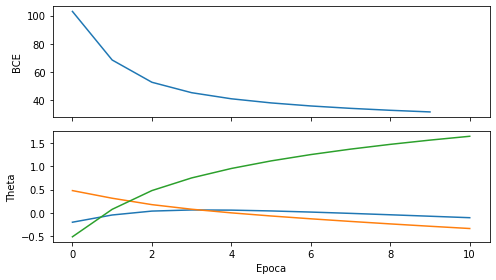

In [9]:
fig, ax = plt.subplots(2, figsize=(7, 4), tight_layout=True, sharex=True)
ax[0].plot(loss)
ax[0].set_ylabel('BCE')
for param in theta.T:
    ax[1].plot(param)
ax[1].set_ylabel('Theta')
ax[1].set_xlabel('Epoca');

Y en este caso, con datos bidimensionales, podemos visualizar como se ajusta el plano separador

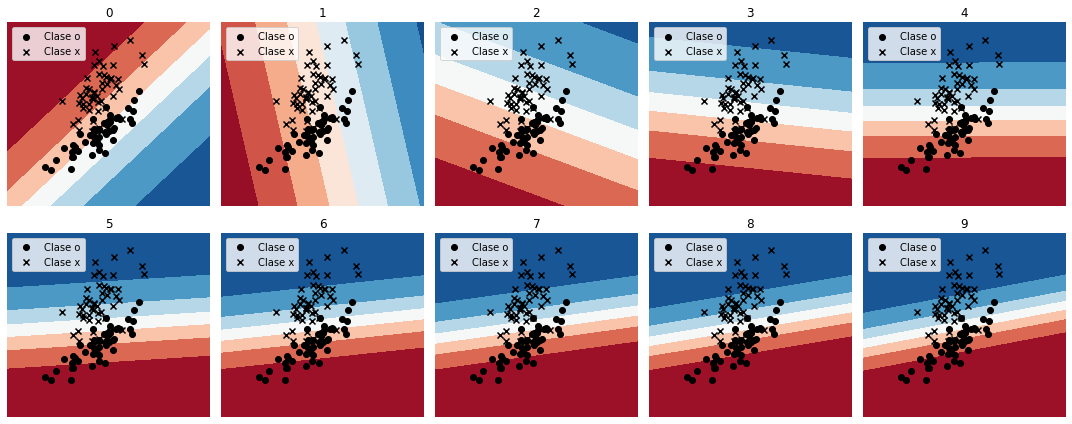

In [10]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True, tight_layout=True)
for k, ax_ in enumerate(ax.ravel()):
    ax_.axis('off')
    plot_prediction(ax_, theta[k, :])
    ax_.set_title(k)

## Regresor logístico en Scikit-Learn

En scikit-learn el regresor logístico está implementado en [`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Los principales argumentos son

- `penalty`: Tipo de regularización, por ejemplo `l2`, `l1` o `'none'`
- `tol`: Tolerancia para el criterio de detención
- `solver`: El algoritmo de optimización a utilizar, por defecto se usa `lbfgs` un método quasi-Newton
- `max_iter`: Número máximo de épocas
- `n_jobs`: Núcleos de CPU a utilizar 

:::{note}

El regresor logístico de scikit-learn puede resolver problemas con más de dos clases

:::

Los principales métodos son

- `fit(X, y)`: Entrenar el modelo con una base de datos `X` y etiquetas `y`
- `predict_proba(X)`: Retorna las probabilidades de clase para los ejemplos `X`
- `predict(X)`: Retorna la clase de mayor probabilidad de `X` (argmax de predict_proba)

Y los principales atributos son

- `intercept_`: Corresponde a $\theta_0$
- `coef_`: Es un arreglo con $\theta_j$ para $j>0$


In [11]:
import sklearn.linear_model

model = sklearn.linear_model.LogisticRegression(penalty='none')
model.fit(X, y)
print(model.intercept_, model.coef_)

display(model.predict_proba(np.array([[1., 0.]])), 
        model.predict(np.array([[1., 0.]])))

[-2.44751183] [[-3.3470849   4.81780968]]


array([[0.99696528, 0.00303472]])

array([0])

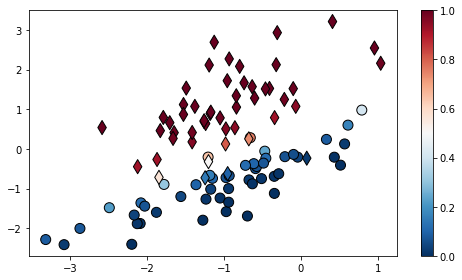

In [12]:
ypred = model.predict_proba(X)[:, 1]
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
for y_, marker in zip(np.unique(y), ['o', 'd']):
    mask = y == y_
    artist = ax.scatter(X[mask, 0], X[mask, 1], c=ypred[mask], marker=marker, s=100,
                        vmin=0, vmax=1, cmap=plt.cm.RdBu_r, edgecolors='k', linewidths=1)
fig.colorbar(artist);

## Métricas: Evaluando un clasificador binario

La salida del regresor logístico es un valor en el rango $[0, 1]$. Para tomar un decisión binaria se debe seleccionar un umbral $\mathcal{T}$ tal que

$$
d_i = 
\begin{cases} 
0, & \text{si } f_\theta(\vec x_i)  < \mathcal{T} \\ 
1, & \text{si } f_\theta(\vec x_i) \geq \mathcal{T}
\end{cases}
$$

Una vez seleccionado el umbral se puede contar la cantidad de 
- **True positives** (TP): Ejemplos de clase (1) y clasificados como (1)
- **True negative** (TN): Ejemplos de clase (0) y clasificados como (0)
- **False positives** (FP): Ejemplos de clase (0) y clasificados como (1): Error tipo I
- **False negative** (FN): Ejemplos de clase (1) y clasificados como (0): Error tipo II

A partir de estas métricas se construye la **tabla de confusión** del clasificador

|Predicho como/Etiqueta|Positivo|Negativo|
|---|---|---|
|Positivo:|TP | FP |
|Negativo:| FN | TN |

Se puede estimar una matriz de confusión con scikit learn con 

In [13]:
import sklearn.metrics

T = 0.5

sklearn.metrics.confusion_matrix(y_true=y, 
                                 y_pred=model.predict_proba(X)[:, 1] > T)

array([[48,  2],
       [ 3, 47]])

En base a la matriz de confusión se calculan otras métricas como

*True Positive Rate* o *Recall*
: La proporción de positivos correctamente clasificados respecto al total de positivos

$$
\text{TPR} = \frac{TP}{TP + FN}
$$

*False Positive Rate* 
: La proporción de negativos incorrectamente clasificados respecto al total de negativos

$$
\text{FPR} = \frac{FP}{TN + FP} = 1 - \frac{TN}{TN + FP}
$$

*Precision* o Pureza
: La proporción de positivos correctamente clasificados respecto a todos los ejemplos clasificados como positivo

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

*Accuracy*
: La proporción de ejemplos correctamente clasificados

$$
\text{Accuracy} = \frac{TP+TN}{TP + FP + FN+ TN}
$$

*F1-score*
: La media armónica entre Recall y Precision asumiendo igual ponderación

$$
\text{f1-score} = \frac{2 \cdot \text{Recall} \cdot \text{Precision}}{\text{Recall} + \text{Precision}}
$$

:::{tip}

Si las clases son desbalanceadas entonces *f1-score* es preferible ante *accuracy*

:::

Podemos obtener estas métricas con scikit-learn utilizando

In [14]:
sklearn.metrics.accuracy_score(y_true=y, y_pred=model.predict_proba(X)[:, 1] > T)

9.5e-01

In [15]:
print(sklearn.metrics.classification_report(y_true=y, y_pred=model.predict_proba(X)[:, 1] > T))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        50
           1       0.96      0.94      0.95        50

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



:::{note}

La matriz de confusión depende del umbral $\mathcal{T}$ 

:::

Podemos estudiar como cambian estas métricas en función del umbral para construir una curva de desempeño. Típicamente se usan

- Curva ROC: TPR vs FPR
- Curva Precision vs Recall

En scikit-learn se pueden calcular con

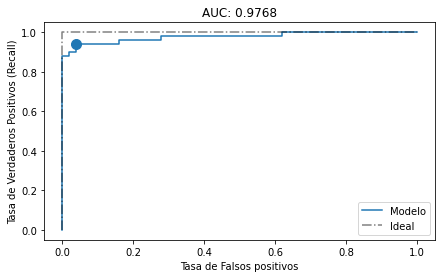

In [16]:
fpr, tpr, th = sklearn.metrics.roc_curve(y_true=y, y_score=model.predict_proba(X)[:, 1])

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(fpr, tpr, label='Modelo')
ax.plot([0, 0, 1], [0, 1, 1], 'k-.', alpha=0.5, label='Ideal')
ax.legend()
idx = np.argmin((th - 0.5)**2)
ax.scatter(fpr[idx], tpr[idx], s=100)
ax.set_xlabel('Tasa de Falsos positivos')
ax.set_ylabel('Tasa de Verdaderos Positivos (Recall)')
ax.set_title(f'AUC: {sklearn.metrics.auc(fpr, tpr)}');

:::{note}

Modificando el umbral podemos ajustar el trade-off entre error tipo 1 y error tipo 2

:::

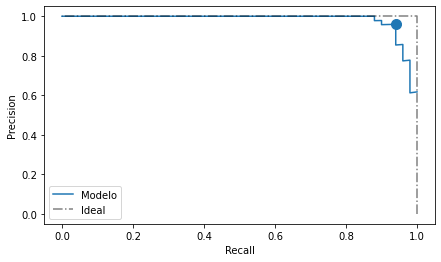

In [17]:
prec, rec, th = sklearn.metrics.precision_recall_curve(y_true=y, probas_pred=model.predict_proba(X)[:, 1])

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(rec, prec, '-', label='Modelo');
ax.plot([1, 1, 0], [0, 1, 1], 'k-.', alpha=0.5, label='Ideal')
ax.legend()
idx = np.argmin((th - 0.5)**2)
ax.scatter(rec[idx], prec[idx], s=100)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision');